In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
from sklearn.exceptions import ConvergenceWarning 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from model_utilities import load_data, preprocess_data, scale_data, evaluate_model, plot_model_scores, apply_grid_search, plot_confusion_matrix, apply_grid_search,apply_random_search

In [18]:
# Load dataframe
df = load_data('https://archive.ics.uci.edu/static/public/329/data.csv')
df.head()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [3]:
# Explore dataframe for number of row and columns, any null values and datatypes. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quality                    1151 non-null   int64  
 1   pre_screening              1151 non-null   int64  
 2   ma1                        1151 non-null   int64  
 3   ma2                        1151 non-null   int64  
 4   ma3                        1151 non-null   int64  
 5   ma4                        1151 non-null   int64  
 6   ma5                        1151 non-null   int64  
 7   ma6                        1151 non-null   int64  
 8   exudate1                   1151 non-null   float64
 9   exudate2                   1151 non-null   float64
 10  exudate3                   1151 non-null   float64
 11  exudate3.1                 1151 non-null   float64
 12  exudate5                   1151 non-null   float64
 13  exudate6                   1151 non-null   float

In [4]:
# Determine if the target is balanced or imbalanced.
df['Class'].value_counts()

Class
1    611
0    540
Name: count, dtype: int64

The target column "Class" is balanced. 

In [5]:
# Additional Columns to get value counts for
columns_to_count = ['quality', 'pre_screening', 'am_fm_classification']

# Iterating through each specified column and printing value counts
for column in columns_to_count:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print() 

Value counts for quality:
quality
1    1147
0       4
Name: count, dtype: int64

Value counts for pre_screening:
pre_screening
1    1057
0      94
Name: count, dtype: int64

Value counts for am_fm_classification:
am_fm_classification
0    764
1    387
Name: count, dtype: int64



The dataset contains largely high quality images, most with severe retinal abnormality. 

In [6]:
# Create X & Y variables & split the data into training and testing sets
X_train, X_test, y_train, y_test = preprocess_data(df, target_column= 'Class')

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,0.996524,0.914253,37.886443,36.447277,34.734647,31.939745,28.464658,20.865585,63.177935,22.551602,8.471935,1.805922,0.556925,0.210038,0.082603,0.034041,0.523627,0.108471,0.329085
std,0.058891,0.280153,25.127629,23.693944,22.447780,20.850447,19.316171,14.847266,59.396794,21.920081,11.721881,3.996278,2.509619,1.022941,0.356737,0.149201,0.027966,0.018160,0.470153
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.349274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367762,0.057906,0.000000
25%,1.000000,1.000000,16.000000,16.000000,15.000000,13.000000,11.000000,8.000000,21.278494,7.663805,1.192884,0.075005,0.000000,0.000000,0.000000,0.000000,0.503378,0.095868,0.000000
50%,1.000000,1.000000,36.000000,35.000000,32.000000,29.000000,25.000000,18.000000,42.769066,16.088890,4.150031,0.467823,0.019493,0.001043,0.000000,0.000000,0.523308,0.106625,0.000000
75%,1.000000,1.000000,55.000000,53.000000,51.000000,47.000000,43.000000,32.000000,82.612023,29.962393,11.237037,1.851928,0.194912,0.036899,0.004869,0.003823,0.543676,0.119809,1.000000
max,1.000000,1.000000,147.000000,132.000000,113.000000,98.000000,97.000000,89.000000,403.939108,167.131427,106.070092,59.766121,51.423208,20.098605,3.739609,1.922177,0.592217,0.219199,1.000000


In [7]:
# Create a list of machine learning models.
models = [("Logistic Regression", LogisticRegression()),
("Support Vector Machine", SVC()),
("K-Nearest Neighbors", KNeighborsClassifier()),
("Decision Tree", DecisionTreeClassifier()),
("Random Forest", RandomForestClassifier()),
("Extremely Random Trees", ExtraTreesClassifier()),
("Gradient Boosting", GradientBoostingClassifier()),
("AdaBoost", AdaBoostClassifier()),
("Naive Bayes", GaussianNB())]


In [8]:
# Scale data and loop through each model, make predictions and evaluate. 
model_scores = []

for name, model in models:
    pipe = Pipeline([('scaler', StandardScaler()),(name, model)])
    model_score  = pipe.fit(X_train, y_train).score(X_test, y_test)
    print(f"Fitting {name}...")
    model_scores.append((name, model_score))
    
    # Predict on the test data
    y_pred = pipe.predict(X_test)
   
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Evaluating {name}...")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    


Fitting Logistic Regression...
Evaluating Logistic Regression...
Accuracy: 0.6753
Confusion Matrix:
[[77 35]
 [40 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       112
           1       0.69      0.66      0.68       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.6797
Confusion Matrix:
[[82 30]
 [44 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       112
           1       0.71      0.63      0.67       119

    accuracy                           0.68       231
   macro avg       0.68      0.68      0.68       231
weighted avg       0.68      0.68      0.68       231

Fitting K-Nearest Neighbors...
Evaluating K-Nearest Ne

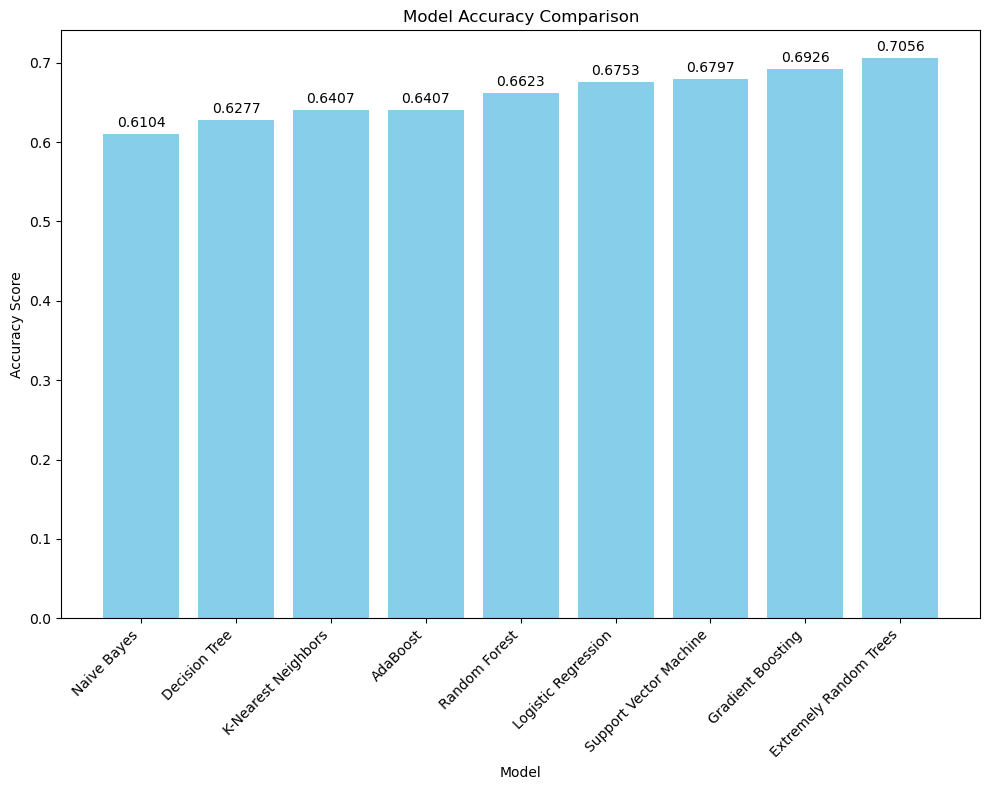

In [9]:
# Plot Model Scores for Comparison
import pandas as pd
plot_model_scores(model_scores)


In [10]:
# Create a dataframe of models and accurracy scores to compare after hyperparemter tuning and feature selection.
accuracy_df = pd.DataFrame(model_scores, columns= ['Model', 'Accuracy'])
accuracy_df.sort_values(by='Accuracy', inplace=True)
accuracy_df

,Model,Accuracy
8,Naive Bayes,0.610390
3,Decision Tree,0.627706
2,K-Nearest Neighbors,0.640693
7,AdaBoost,0.640693
4,Random Forest,0.662338
0,Logistic Regression,0.675325
1,Support Vector Machine,0.679654
6,Gradient Boosting,0.692641
5,Extremely Random Trees,0.705628


Hyperparameter tuning using GridSearchCV

In [11]:
# Define models and their parameter grids
models_with_params = [
    (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }),
    (RandomForestClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30]
    }),
    (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (ExtraTreesClassifier(), {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }),
    (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }),
    # GaussianNB does not have hyperparameters that are commonly tuned, so it's not included in GridSearch
]

# Apply GridSearchCV to each model
results = apply_grid_search(models_with_params, X_train, y_train)

# Display the results
for result in results:
    print(f"Model: {result['model']}, Best Params: {result['best_params']}, Best Score: {result['best_score']}")

/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jenniferleone/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jenniferleone/anac

Model: LogisticRegression, Best Params: {'C': 10, 'solver': 'liblinear'}, Best Score: 0.7576086956521739
Model: RandomForestClassifier, Best Params: {'max_depth': 20, 'n_estimators': 100}, Best Score: 0.6880434782608695
Model: SVC, Best Params: {'C': 0.1, 'kernel': 'linear'}, Best Score: 0.7543478260869565
Model: DecisionTreeClassifier, Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}, Best Score: 0.6326086956521739
Model: ExtraTreesClassifier, Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, Best Score: 0.7195652173913044
Model: GradientBoostingClassifier, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}, Best Score: 0.7021739130434782
Model: AdaBoostClassifier, Best Params: {'learning_rate': 1, 'n_estimators': 200}, Best Score: 0.6902173913043479


In [12]:
#  Create dataframe that contains the GridSearchCV results 

gscv_hyperparam_tuning_df = pd.DataFrame(results)
gscv_hyperparam_tuning_df.sort_values(by='best_score', inplace=True)
gscv_hyperparam_tuning_df

,model,best_params,best_score
3,DecisionTreeClassifier,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.632609
1,RandomForestClassifier,"{'max_depth': 20, 'n_estimators': 100}",0.688043
6,AdaBoostClassifier,"{'learning_rate': 1, 'n_estimators': 200}",0.690217
5,GradientBoostingClassifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.702174
4,ExtraTreesClassifier,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",0.719565
2,SVC,"{'C': 0.1, 'kernel': 'linear'}",0.754348
0,LogisticRegression,"{'C': 10, 'solver': 'liblinear'}",0.757609


In [13]:
# Clean dataframe before concatenating
# Match values in gscv_hyperparam_tuning_df['model'] column to accuracy_df['Model']

mapping = {'LogisticRegression': 'Logistic Regression',
            'DecisionTreeClassifier' :'Decision Tree',
            'ExtraTreesClassifier' :'Extremely Random Trees',
            'RandomForestClassifier' : 'Random Forest',
            'SVC' :'Support Vector Machine',
            'GradientBoostingClassifier' :'Gradient Boosting',
            'AdaBoostClassifier' :'AdaBoost',
            }

gscv_hyperparam_tuning_df['model'] = gscv_hyperparam_tuning_df['model'].map(mapping)
gscv_hyperparam_tuning_df= gscv_hyperparam_tuning_df.rename(columns={'model': 'Model'})
gscv_hyperparam_tuning_df

,Model,best_params,best_score
3,Decision Tree,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.632609
1,Random Forest,"{'max_depth': 20, 'n_estimators': 100}",0.688043
6,AdaBoost,"{'learning_rate': 1, 'n_estimators': 200}",0.690217
5,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.702174
4,Extremely Random Trees,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",0.719565
2,Support Vector Machine,"{'C': 0.1, 'kernel': 'linear'}",0.754348
0,Logistic Regression,"{'C': 10, 'solver': 'liblinear'}",0.757609


Model Performance before and after Hyperparameter Tuning. 

In [17]:
# Merge accuracy_df and gscv_hyperparam_tuning_df.
comparison_df1 = pd.merge(gscv_hyperparam_tuning_df, accuracy_df, on='Model', how='outer')

# Add a column 'Improvement' to the merged dataframe.
comparison_df1['Improvement'] = comparison_df1['best_score'] - comparison_df1['Accuracy']

# Sort the dataframe by 'Improvement' in descending order.
comparison_df1.sort_values(by='Improvement', ascending=False, inplace=True)

# Reset the index of the dataframe.
comparison_df1 = comparison_df1.reset_index(drop=True)
comparison_df1

,Model,best_params,best_score,Accuracy,Improvement
0,Logistic Regression,"{'C': 10, 'solver': 'liblinear'}",0.757609,0.675325,0.082284
1,Support Vector Machine,"{'C': 0.1, 'kernel': 'linear'}",0.754348,0.679654,0.074694
2,AdaBoost,"{'learning_rate': 1, 'n_estimators': 200}",0.690217,0.640693,0.049525
3,Random Forest,"{'max_depth': 20, 'n_estimators': 100}",0.688043,0.662338,0.025706
4,Extremely Random Trees,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",0.719565,0.705628,0.013938
5,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.702174,0.692641,0.009533
6,Decision Tree,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.632609,0.627706,0.004903
7,Naive Bayes,NaN,NaN,0.610390,NaN
8,K-Nearest Neighbors,NaN,NaN,0.640693,NaN


## Feature Selection:

Use techniques to select the most informative features.

**Recursive Feature Elimination (RFE):**

Recursive Feature Elimination (RFE) works by recursively removing features and building a model on those features that remain. It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

In [24]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# Create X & y variables 
X = df.drop('Class', axis=1)
y = df['Class']

# Create a logistic regression model and use RFE to select the top 10 features.
model = LogisticRegression()
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X, y)

# The mask of selected features.
selected_features_mask = selector.support_

# Get the names of the selected features based on the mask
selected_feature_names = X.columns[selected_features_mask].tolist()

print("Selected features:", selected_feature_names)


Selected features: ['quality', 'pre_screening', 'ma1', 'ma2', 'ma3', 'exudate6', 'exudate7', 'exudate8', 'opticdisc_diameter', 'am_fm_classification']


In [37]:
# Create X with selected features
columns_to_include = selected_feature_names
# columns_to_drop = ['quality', 'pre_screening', 'am_fm_classification']

# Create a new DataFrame with only the selected columns
X_sel = df[columns_to_include] 
# X_sel = df.drop(columns_to_drop, axis=1)
y = df['Class']

# Split the data into training and testing sets
X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=1)

In [38]:
# Scale Data
scaler = StandardScaler()
X_sel_train_scaled = scaler.fit_transform(X_sel_train)
X_sel_test_scaled = scaler.transform(X_sel_test)

In [39]:
# Create the logistic regression classifier model with hyperparameter tuning resluts: C': 10, 'solver': 'liblinear'
from sklearn.metrics import accuracy_score
lr_model = LogisticRegression(random_state=1, max_iter=500, C=10, solver='liblinear')

# Fit the model to the training data
lr_model.fit(X_sel_train_scaled, y_train)



LogisticRegression(C=10, max_iter=500, random_state=1, solver='liblinear')

In [40]:
# Validate the model by checking the model accuracy with model.score
print(f"Training Data Score: {lr_model.score(X_sel_train_scaled, y_train)}")
print(f"Testing Data Score: {lr_model.score(X_sel_test_scaled, y_test)}")

Training Data Score: 0.7423913043478261
Testing Data Score: 0.696969696969697


**Results of tunning and feature selection for Logistic Regression Model**

Original accuracy score with default parameters and full set of features: 
- 0.675325

---
Best score with Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
- 0.7195652173913044

---
Selected features: columns to include = ['quality', 'pre_screening', 'ma1', 'ma2', 'ma3', 'exudate6', 'exudate7', 'exudate8', 'opticdisc_diameter', 'am_fm_classification']

- Training Data Score: 0.7423913043478261
- Testing Data Score: 0.696969696969697

---

Selected features: columns_to_drop = ['quality', 'pre_screening', 'am_fm_classification']

- Training Data Score: 1.0
- Testing Data Score: 1.0



**Feature Importance from Extremely Random Trees which initailly had the highest Accuracy Score of 0.705628	 :**
Feature_importances_ is used for tree-based models such as DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, and AdaBoostClassifier with a tree base learner.

In [51]:
# Fit the model
model = ExtraTreesClassifier()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# List the top 15 most important features
importances_sorted = sorted(zip(importances, X.columns), reverse=True)
column_names = [column_name for importance, column_name in importances_sorted]

importances_sorted[:15]

[(0.1049844863014207, 'ma1'),
 (0.07460224783374635, 'ma2'),
 (0.07312875907637344, 'exudate1'),
 (0.06678481769144388, 'ma3'),
 (0.06587574301421273, 'ma5'),
 (0.0624002444396989, 'ma4'),
 (0.06156763609925478, 'ma6'),
 (0.05997107542228074, 'exudate2'),
 (0.05842567167369297, 'exudate3'),
 (0.05513340634980485, 'macula_opticdisc_distance'),
 (0.054786778967587824, 'exudate3.1'),
 (0.054467585934264866, 'opticdisc_diameter'),
 (0.045045783933785326, 'exudate5'),
 (0.04500235071016024, 'exudate7'),
 (0.04050388554463225, 'exudate6')]

In [52]:
# Create X with top 15 selected features
columns_to_include =column_names[:15]

# Create a new DataFrame with only the selected columns
X_sel = df[columns_to_include] 
y = df['Class']

# Split the data into training and testing sets
X_sel_train, X_sel_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=1)

In [56]:
# Train the Extremely Random Trees classifier
# ert = ExtraTreesClassifier(random_state=1).fit(X_sel_train_scaled, y_train)
ert = ExtraTreesClassifier(max_depth=20, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 100, random_state=1).fit(X_sel_train_scaled, y_train)

# Validate the model by checking the model accuracy with model.score
print(f"Training Data Score: {ert.score(X_sel_train_scaled, y_train)}")
print(f"Testing Data Score: {ert.score(X_sel_test_scaled, y_test)}")

Training Data Score: 0.7597826086956522
Testing Data Score: 0.6623376623376623


**Results of hyperparameter tunning and feature selection for Extremely Random Trees Classifier**

Original accuracy score with default parameters and full set of features: 
- 0.705628

---
Best_score with Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
- 0.719565

---
Top 15 selected features: ['ma1','ma2','exudate1','ma3','ma5','ma4',ma6','exudate2','exudate3','macula_opticdisc_distance','exudate3.1','opticdisc_diameter','exudate5','exudate7','exudate6']

- Training Data Score: 1.0
- Testing Data Score: 0.6406926406926406

---
Top 15 selected features and Best Params:
- Training Data Score: 0.7597826086956522
- Testing Data Score: 0.6623376623376623



